<a href="https://colab.research.google.com/github/St-Jester/cv_hw4/blob/main/3drec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# we need this to support OpenGL in Gooogle Colab

%tensorflow_version 1.x
!pip install -q lucid==0.2.3

TensorFlow 1.x selected.
     |████████████████████████████████| 40kB 5.7MB/s 


In [3]:
import numpy as np
import json
from google.colab import files
from math import *
import lucid.misc.io.showing as show
from lucid.misc.gl.glcontext import create_opengl_context
# Now it's safe to import OpenGL and EGL functions
import OpenGL.GL as gl

In [4]:
# create_opengl_context() creates GL context that is attached to an
# offscreen surface of specified size. Note that rendering to buffers
# of different size and format is still possible with OpenGL Framebuffers.
#
# Users are expected to directly use EGL calls in case more advanced
# context management is required.
WIDTH, HEIGHT = 512, 512
create_opengl_context((WIDTH, HEIGHT))
    
# OpenGL context is available here.

print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 
#print(gl.glGetString(gl.GL_EXTENSIONS))

b'4.6.0 NVIDIA 418.67'
b'NVIDIA Corporation'


In [14]:
# screenshot from the Witcher 3. camera angle 91. no shadows in render. no calibration
!wget 'https://drive.google.com/uc?export=download&id=1EcWH5RZVJAKsA4-qVRCS-fCiL_eY-ytB' -O imgs.zip
!unzip -oq imgs.zip

--2020-12-31 16:14:36--  https://drive.google.com/uc?export=download&id=1EcWH5RZVJAKsA4-qVRCS-fCiL_eY-ytB
Resolving drive.google.com (drive.google.com)... 142.250.73.206, 2607:f8b0:4004:829::200e
Connecting to drive.google.com (drive.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kk85peedofg35klb14m76261j7gtelbs/1609431225000/04006984608115690918/*/1EcWH5RZVJAKsA4-qVRCS-fCiL_eY-ytB?e=download [following]
--2020-12-31 16:14:37--  https://doc-0k-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kk85peedofg35klb14m76261j7gtelbs/1609431225000/04006984608115690918/*/1EcWH5RZVJAKsA4-qVRCS-fCiL_eY-ytB?e=download
Resolving doc-0k-ao-docs.googleusercontent.com (doc-0k-ao-docs.googleusercontent.com)... 172.217.9.193, 2607:f8b0:4004:806::2001
Connecting to doc-0k-ao-docs.googleusercontent.com (doc-0k-ao-docs.g

In [15]:
import cv2
import numpy as np
from math import *
from skimage import io
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [16]:
img1_orig = cv2.imread('The Witcher 3 Screenshot 2020.12.29 - 01.42.39.38.png')
img2_orig = cv2.imread('The Witcher 3 Screenshot 2020.12.29 - 01.42.31.71.png')
img3_orig = cv2.imread('The Witcher 3 Screenshot 2020.12.29 - 01.42.21.11.png')

def make_smaller(img, amount = 30): 
  w = int(img.shape[1] * amount / 100)
  h = int(img.shape[0] * amount / 100)
  dim = (w, h)
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized

# cv2_imshow(make_smaller(img_with_markers(img1_orig,point_coords_im1,marker_colors ), 50))
# cv2_imshow(make_smaller(img_with_markers(img2_orig,point_coords_im2,marker_colors ), 50))
# cv2_imshow(make_smaller(img_with_markers(img3_orig,point_coords_im3,marker_colors ), 50))


Computing the disparity  map...


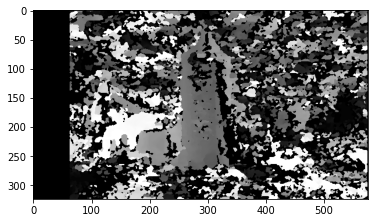

In [17]:
h,w = img1_orig.shape[:2]

img1_small = make_smaller(img1_orig)

img2_small = make_smaller(img2_orig)

win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16


stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
 numDisparities = num_disp,
 blockSize = 5,
 uniquenessRatio = 5,
 speckleWindowSize = 5,
 speckleRange = 5,
 disp12MaxDiff = 1,
 P1 = 8*3*win_size**2,#8*3*win_size**2,
 P2 =32*3*win_size**2) #32*3*win_size**2)

 #Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img1_small, img2_small)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map,'gray')
plt.show()

In [27]:
#Get new downsampled width and height 
h,w = img2_small.shape[:2]
focal_length = 1.6
Q = np.float32([[1,0,0,-w/2.0],
    [0,-1,0,h/2.0],
    [0,0,0,-focal_length],
    [0,0,1,0]])

Q2 = np.float32([[1,0,0,0],
    [0,-1,0,0],
    [0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. 
    [0,0,0,1]])

#Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q2)
#Get color points
colors = cv2.cvtColor(img1_small, cv2.COLOR_BGR2RGB)


#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()
#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]
#Define name for output file

# code to create point clous taken from here:
# https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
import struct
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')


output_file = 'reconstructed.ply'
#Generate point cloud 
print ("\n Creating the output file... \n")
write_ply(output_file, output_points, output_colors)



 Creating the output file... 



In [28]:
!ls
# needs to have reconstructed.ply file in the list

 img1_points.png     sample_data
 img2_points.png    'The Witcher 3 Screenshot 2020.12.29 - 01.42.21.11.png'
 img3_points.png    'The Witcher 3 Screenshot 2020.12.29 - 01.42.31.71.png'
 imgs.zip	    'The Witcher 3 Screenshot 2020.12.29 - 01.42.39.38.png'
 reconstructed.ply


In [29]:
from google.colab import files
files.download('reconstructed.ply') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

to open the file I usedhttp://meshlab.sourceforge.net/  and opened it on my pc



In [32]:
# snapshots of redered scene

# screenshot from the Witcher 3. camera angle 91. no shadows in render. no calibration
!wget 'https://drive.google.com/uc?export=download&id=1EW95gnZtxsyzVQPKKPiF5fPeYGN_Hs41' -O snapshots.zip
!unzip -oq snapshots.zip

--2020-12-31 16:45:40--  https://drive.google.com/uc?export=download&id=1EW95gnZtxsyzVQPKKPiF5fPeYGN_Hs41
Resolving drive.google.com (drive.google.com)... 142.250.73.206, 2607:f8b0:4004:829::200e
Connecting to drive.google.com (drive.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d6umqdpb4q24fj2q2f53qbs1g23kf8fo/1609433100000/04006984608115690918/*/1EW95gnZtxsyzVQPKKPiF5fPeYGN_Hs41?e=download [following]
--2020-12-31 16:45:41--  https://doc-00-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d6umqdpb4q24fj2q2f53qbs1g23kf8fo/1609433100000/04006984608115690918/*/1EW95gnZtxsyzVQPKKPiF5fPeYGN_Hs41?e=download
Resolving doc-00-ao-docs.googleusercontent.com (doc-00-ao-docs.googleusercontent.com)... 172.217.9.193, 2607:f8b0:4004:806::2001
Connecting to doc-00-ao-docs.googleusercontent.com (doc-00-ao-docs.g

In [34]:
!ls

 img1_points.png     snapshots
 img2_points.png     snapshots.zip
 img3_points.png    'The Witcher 3 Screenshot 2020.12.29 - 01.42.21.11.png'
 imgs.zip	    'The Witcher 3 Screenshot 2020.12.29 - 01.42.31.71.png'
 reconstructed.ply  'The Witcher 3 Screenshot 2020.12.29 - 01.42.39.38.png'
 sample_data


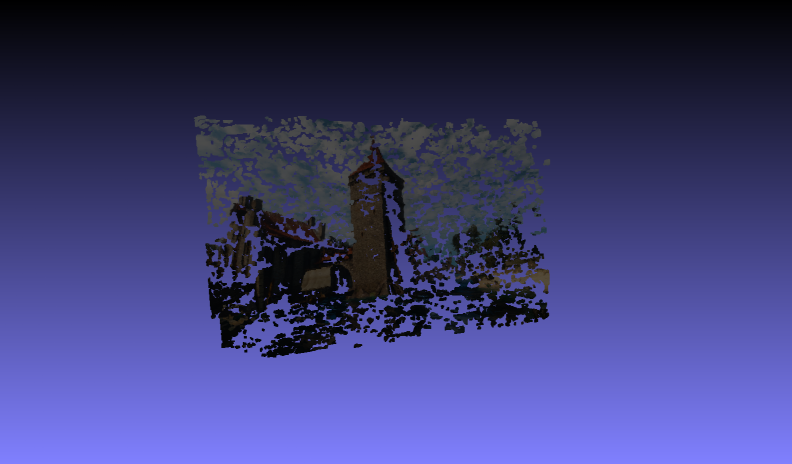

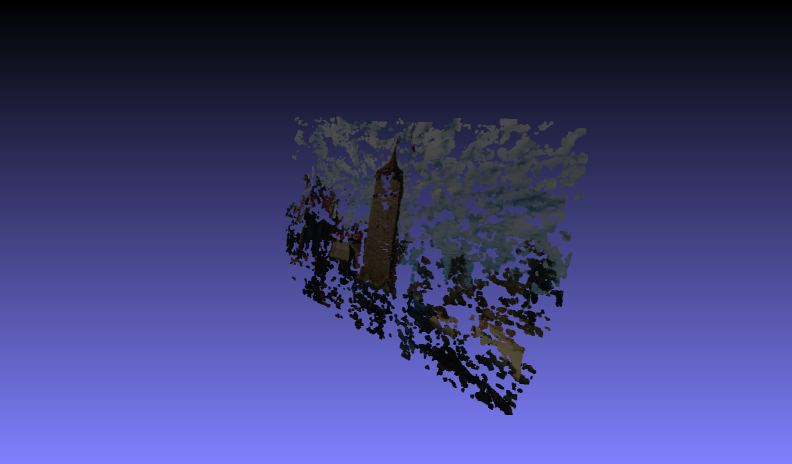

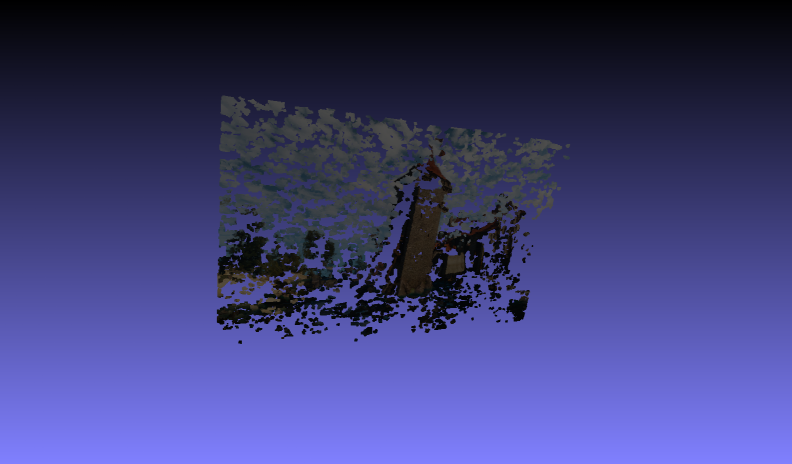

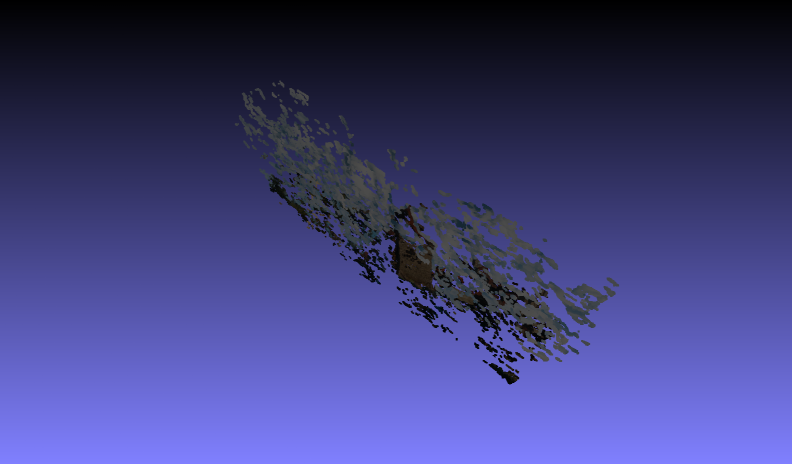

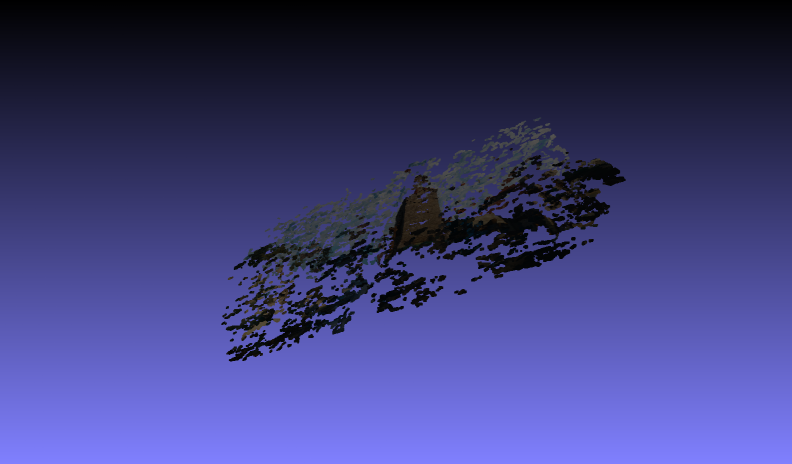

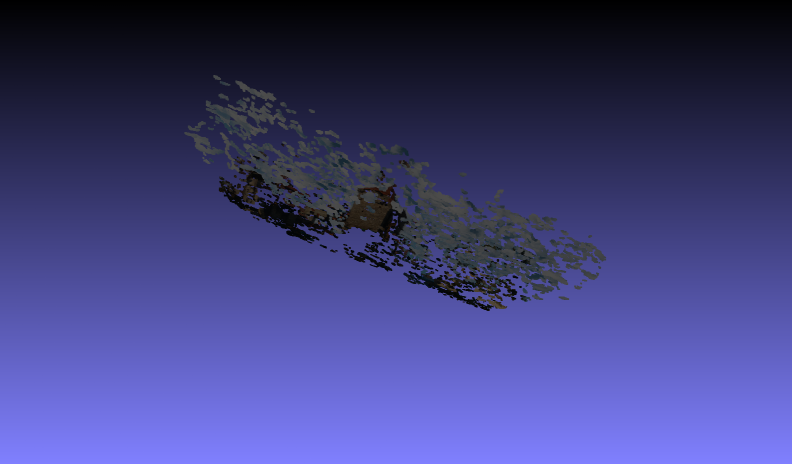

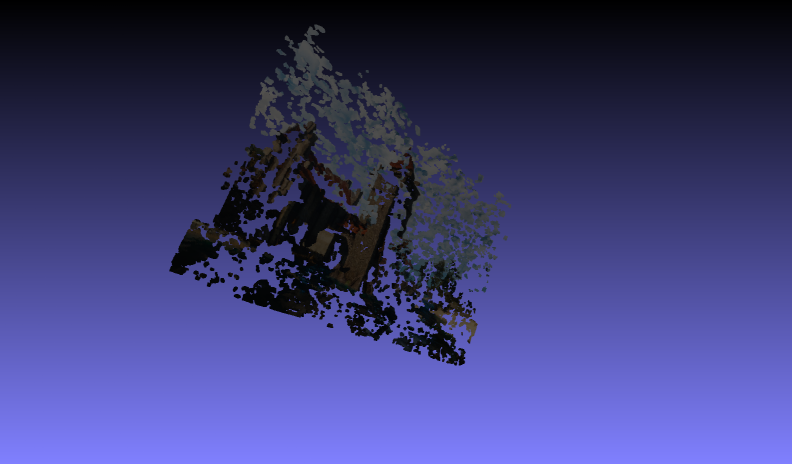

In [35]:
img1_snap = cv2.imread('./snapshots/snapshot00.png')
img2_snap = cv2.imread('./snapshots/snapshot01.png')
img3_snap = cv2.imread('./snapshots/snapshot02.png')
img4_snap = cv2.imread('./snapshots/snapshot03.png')
img5_snap = cv2.imread('./snapshots/snapshot04.png')
img6_snap = cv2.imread('./snapshots/snapshot05.png')
img7_snap = cv2.imread('./snapshots/snapshot06.png')


cv2_imshow(make_smaller(img1_snap, 50))
cv2_imshow(make_smaller(img2_snap, 50))
cv2_imshow(make_smaller(img3_snap, 50))
cv2_imshow(make_smaller(img4_snap, 50))
cv2_imshow(make_smaller(img5_snap, 50))
cv2_imshow(make_smaller(img6_snap, 50))
cv2_imshow(make_smaller(img7_snap, 50))